## K-means
Dentro de las tecnicas no supervisadas estan los algoritmos de clusterizacion. Que consiste en agrupar los elementos que tienen similaridad.

### Cuando utilizar un clusters?
Normalmente se utilizan cuando no tenemos etiquetas de los datos para predecir. En este caso se busca agrupar la informacion en grupos que pueden ser utilizados para conocer la posible etiqueta de los datos.

### Algoritmo
1 Seleccionar K, numero de grupos en los datos.

2 Asignar los datos a un cluster o grupo aleatorio

3 Calcular el centroide. Este es el el promedio de todos los puntos.

4 Medir la distancia del punto a cada centroide y asignar el cluster mas cercano como etiqueta.

5 Si no existe ningun cambio en la asignacion, el algoritmo finalizo. Sino volver al paso 3 


El Objetivo es minimizar la distancia entre los puntos asignados al grupo y el centroide.

$Min(\sum^{i \in K}_{i=0}\sum_{x \in S_i}(X-\mu_i)^2 )$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class Kmeans:
    
    def __init__(self, k):
        self.k = k
        self.mu = None
        self.his_mu = []
        
    def calculate_labels(self,X):
        # Using Distance formula -2X*MU  + X^2 + MU^2
        dis = -2 * np.dot(X, self.mu.T) 
        dis = dis + np.power(X, 2).sum(axis=1).reshape((-1, 1))
        dis = dis + np.power(self.mu,2).sum(axis=1)
        n_l = dis.argsort(axis=1)[:,0].reshape((-1,1))
        return n_l
    
    def train(self, X, verbose=False):
        X = np.array(X)
        l = np.random.randint(0,high=self.k,size=(X.shape[0],1))
        n_l = None
        while n_l is None or not np.array_equal(l,n_l):
            cur_mu = []
            if n_l is not None:
                l = n_l
            X_l = np.hstack((X,l))
            for i in range(self.k):
                cur_mu.append( 
                    np.mean(
                        X_l[np.where(X_l[:,-1]==i),:-1],
                        axis=1
                    )
                )
            self.mu = np.vstack(cur_mu) 
            self.his_mu.append(self.mu)
            n_l = self.calculate_labels(X)
            if verbose: print(self.mu)
                
    def predict(self,X):
        n_l = self.calculate_labels(X)
        return n_l

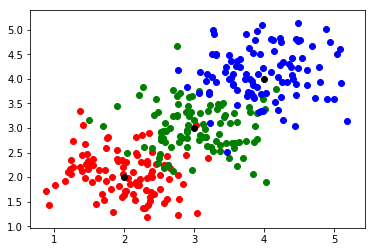

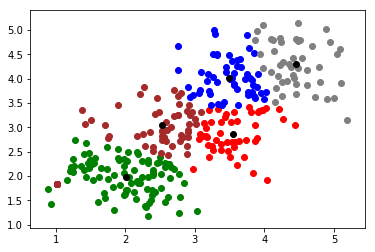

In [9]:
s_row = 100
mu_data = [2,3,4]
X = np.vstack( (np.random.normal(mu_data[0],0.5,size=(s_row,2)),
               np.random.normal(mu_data[1],0.5,size=(s_row,2)),
               np.random.normal(mu_data[2],0.5,size=(s_row,2)))
             )
fig, ax = plt.subplots(1,1)
ax.scatter(X[:s_row,0],X[:s_row,1],c='r')
ax.scatter(X[s_row:2*s_row,0],X[s_row:2*s_row,1],c='g')
ax.scatter(X[2*s_row:,0],X[2*s_row:,1],c='b')
ax.scatter(mu_data,
           mu_data, c='black')


fig, ax = plt.subplots(1,1)
kmeans = Kmeans(5)
kmeans.train(X)
label = kmeans.predict(X)
 
ax.scatter(X[np.where(label==0),0],X[np.where(label==0),1],c='r')
ax.scatter(X[np.where(label==1),0],X[np.where(label==1),1],c='b')
ax.scatter(X[np.where(label==2),0],X[np.where(label==2),1],c='g')
ax.scatter(X[np.where(label==3),0],X[np.where(label==3),1],c='gray')
ax.scatter(X[np.where(label==4),0],X[np.where(label==4),1],c='brown')
ax.scatter(kmeans.mu[:,0],
           kmeans.mu[:,1], c='black')

In [10]:
import os
import glob
import pickle
import numpy as np
import itertools
from urllib.request import urlretrieve
from os.path import isfile, isdir
from sklearn.decomposition import PCA
import tarfile

def download_files():
    """
    Este metodo descarga los archivos de imagenes sino existen
    """
    path_tar = os.path.join("data",'cifar-10-python.tar.gz')
    if not isfile(path_tar):
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            path_tar)
    dest_path =  "data"
    with tarfile.open(path_tar) as tar:
        tar.extractall(dest_path)
        tar.close()
download_files()

def get_data():
    """
    Este metodo lee los archivos descargados y crea una matriz con todos los ejemplos
    """
    folder = os.path.join("data",'cifar-10-batches-py')
    list_train = []
    test = None
    names_labels = None
    for n_file in glob.os.listdir(folder):
        if '_batch' in n_file:
            with open(os.path.join(folder,n_file),'rb') as temp_file:
                
                if 'test' in temp_file.name:
                    test = pickle.load(temp_file, encoding='latin1')
                else:
                    list_train.append(pickle.load(temp_file, encoding='latin1'))
        elif 'batches.meta' in n_file:
            with open(os.path.join(folder,n_file),'rb') as temp_file:
                names_labels = pickle.load(temp_file, encoding='latin1')["label_names"]
    X_test = test["data"]
    y_test = test["labels"]
    X_train = None
    y_train = None
    while len(list_train)>0:
        elem_dic = list_train.pop()
        if X_train is None:
            X_train = elem_dic["data"]
            y_train = elem_dic["labels"]
        else:
            X_train = np.concatenate((X_train, elem_dic["data"]),axis=0)
            y_train = np.concatenate((y_train, elem_dic["labels"]),axis=0)
    return X_train, y_train, X_test, y_test, names_labels  
fn_shape = lambda X: X.reshape(3, 32, 32).transpose(1, 2, 0)
X_train, y_train, X_test, y_test, names_labels = get_data()

Explained variation per principal component: 0.9008930302644425
Explained variation per principal component: 0.40255556101479495


<Figure size 432x288 with 0 Axes>

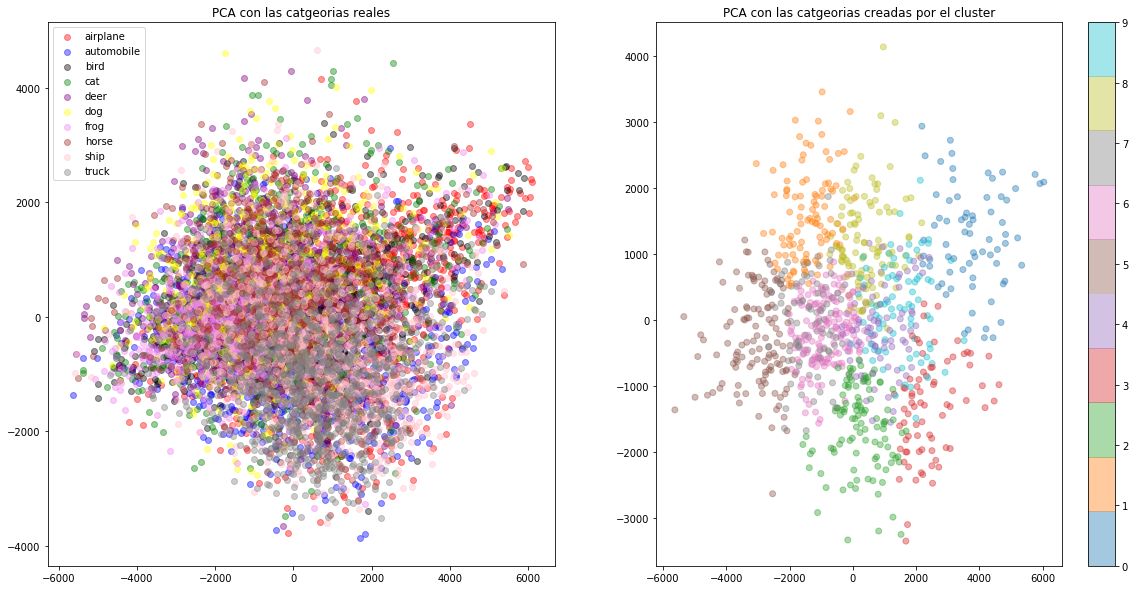

In [210]:
def reduce_dim_pca(components, X_train, X_test):
    """
    This method reduce the dimensionality of the Train and Test Matrix.
    """
    pca = PCA(n_components=components)
    X_r = pca.fit(X_train).transform(X_train)
    X_nr = pca.transform(X_test)
    text = 'Explained variation per principal component: {}'
    print(text.format(np.sum(pca.explained_variance_ratio_[:components])))
    return X_r, X_nr

l = 1000
l_t = 30
s_X_train, s_y_train = X_train[:l], y_train[:l]
s_X_test, s_y_test = X_test[:l_t], y_test[:l_t]

# Clusterizamos en una dimension menor
X_r, X_nr = reduce_dim_pca(100, s_X_train, s_X_test)
#X_r, X_nr = s_X_train, s_y_train
k = 10
kmeans = Kmeans(k)
kmeans.train(X_r)
labels = kmeans.predict(X_r)
s_y_train_cluster = labels[:,0]

c_scale = ['red', 'blue', 'black','green',
           'purple','yellow','violet',
           'brown','pink','gray']
dict_colors = [(ix,color) 
          for ix, color in enumerate(c_scale)]
lw = 1
# Reducir la dimensionalidad para dibujar
X_r, X_nr = reduce_dim_pca(2, s_X_train, s_X_test)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,10))
for color, target_name in zip(dict_colors,names_labels ):
    ax[0].scatter(X_r[s_y_train == color[0], 0], X_r[s_y_train == color[0], 1],
                color=color[1], alpha=.4, lw=lw,
                label=target_name)
ax[0].legend(loc='best', shadow=False, scatterpoints=1)
ax[0].set_title("PCA con las catgeorias reales")

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

ax[1].set_title("PCA con las catgeorias creadas por el cluster")
scat = ax[1].scatter(X_r[:, 0], X_r[:, 1],c=s_y_train_cluster,
            cmap='tab10', alpha=.4, lw=lw)
cb = plt.colorbar(scat, spacing='proportional',ticks=range(k))
plt.show()

En la anterior grafica, se puede observar que el Kmeans hace su trabajo de dividir los datos en grupos. Sin embargo, la division de los datos realizada por el Kmeans no corresponde a los datos reales.

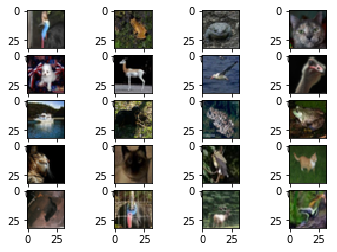

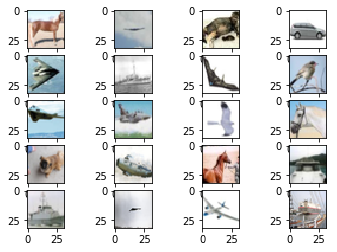

In [178]:
s_y_train = s_y_train_cluster
def plot_group(s_X_train,s_y_train, group = 5, f_num = 21, f_col = 4, is_gray=False):
    f_rows = int((0.5+f_num)/f_col)
    fig = plt.figure()
    for f_i in range(1,f_num):
        ax = fig.add_subplot(f_rows,f_col,f_i)
        if is_gray:
            ax.imshow(s_X_train[np.where(s_y_train==group)][f_i].reshape(32,32))
        else:
            ax.imshow(fn_shape(s_X_train[np.where(s_y_train==group)][f_i]))
        
plot_group(s_X_train,s_y_train, group = 6, f_num = 21, f_col = 4)
plot_group(s_X_train,s_y_train, group = 5, f_num = 21, f_col = 4)

In [179]:
X_r, X_nr =  s_X_train, s_X_test
#X_r, X_nr = s_X_train, s_y_train
k = 10
kmeans = Kmeans(k)
kmeans.train(X_r)
labels = kmeans.predict(X_r)
s_y_train_cluster = labels[:,0]

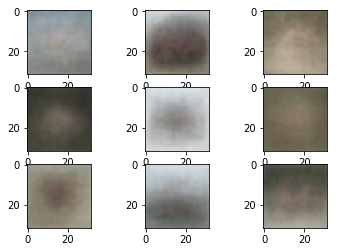

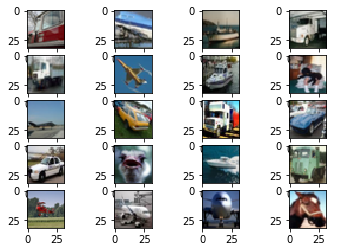

In [207]:
fig,ax = plt.subplots(3,3)
ax[0,0].imshow(fn_shape(np.asarray(kmeans.mu[0], dtype=int)))
ax[0,1].imshow(fn_shape(np.asarray(kmeans.mu[1], dtype=int)))
ax[0,2].imshow(fn_shape(np.asarray(kmeans.mu[2], dtype=int)))
ax[1,0].imshow(fn_shape(np.asarray(kmeans.mu[3], dtype=int)))
ax[1,1].imshow(fn_shape(np.asarray(kmeans.mu[4], dtype=int)))
ax[1,2].imshow(fn_shape(np.asarray(kmeans.mu[5], dtype=int)))
ax[2,0].imshow(fn_shape(np.asarray(kmeans.mu[6], dtype=int)))
ax[2,1].imshow(fn_shape(np.asarray(kmeans.mu[7], dtype=int)))
ax[2,2].imshow(fn_shape(np.asarray(kmeans.mu[8], dtype=int)))

plot_group(s_X_train,s_y_train, group = 1, f_num = 21, f_col = 4)

## PCA sin Color
Vamos a repetir el experimento con una escala de grises

Explained variation per principal component: 0.9345543573535108
Explained variation per principal component: 0.4375229887454946


<Figure size 432x288 with 0 Axes>

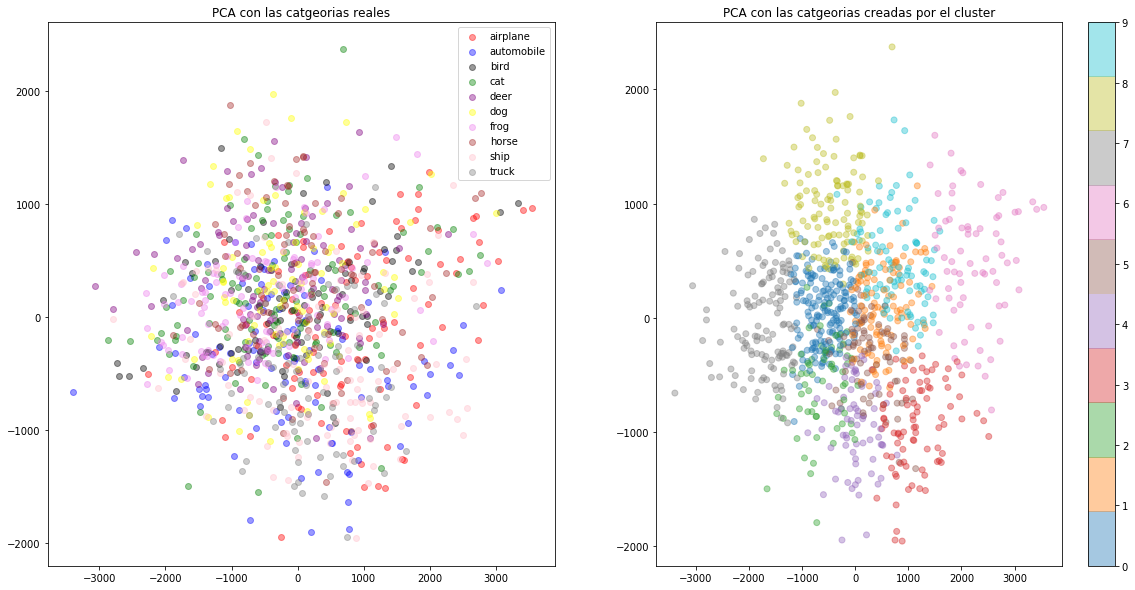

In [208]:
fn_shape = lambda X: X.reshape(3, 32, 32).transpose(1, 2, 0)
def rgb2gray(rgb, is_flat=True):
    rgb = fn_shape(rgb)
    img = np.dot(rgb[...,:3], [0.2125, 0.7154, 0.0721])
    if is_flat:
        img = img.flatten()
    return img   
l = 1000
l_t = 30
s_X_train, s_y_train = np.apply_along_axis(rgb2gray,1,X_train[:l]), y_train[:l]
s_X_test, s_y_test = np.apply_along_axis(rgb2gray,1, X_test[:l_t]), y_test[:l_t]
# Clusterizamos en una dimension menor
X_r, X_nr = reduce_dim_pca(100, s_X_train, s_X_test)
#X_r, X_nr = s_X_train, s_y_train
k = 10
kmeans = Kmeans(k)
kmeans.train(X_r)
labels = kmeans.predict(X_r)
s_y_train_cluster = labels[:,0]

c_scale = ['red', 'blue', 'black','green',
           'purple','yellow','violet',
           'brown','pink','gray']
dict_colors = [(ix,color) 
          for ix, color in enumerate(c_scale)]
lw = 1

# Reducir la dimensionalidad para dibujar
X_r, X_nr = reduce_dim_pca(2, s_X_train, s_X_test)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,10))
for color, target_name in zip(dict_colors,names_labels ):
    ax[0].scatter(X_r[s_y_train == color[0], 0], X_r[s_y_train == color[0], 1],
                color=color[1], alpha=.4, lw=lw,
                label=target_name)
ax[0].legend(loc='best', shadow=False, scatterpoints=1)
ax[0].set_title("PCA con las catgeorias reales")

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

ax[1].set_title("PCA con las catgeorias creadas por el cluster")
scat = ax[1].scatter(X_r[:, 0], X_r[:, 1],c=s_y_train_cluster,
            cmap='tab10', alpha=.4, lw=lw)
cb = plt.colorbar(scat, spacing='proportional',ticks=range(k))
plt.show()

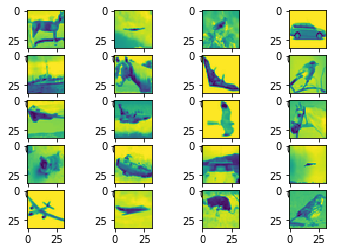

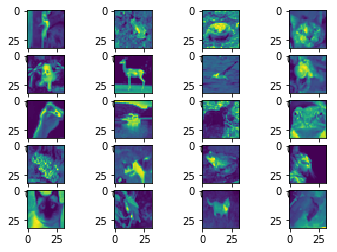

In [172]:
plot_group(s_X_train,s_y_train_cluster, group = 2, f_num = 21, f_col = 4, is_gray=True)
plot_group(s_X_train,s_y_train_cluster, group = 7, f_num = 21, f_col = 4, is_gray=True)

Podemos concluir que es dificil utilizar tecnicas lineales como PCA, para agrupar las imagenes de este dataset. Aun utilizando escala de grises no podemos encontrar los grupos de imagenes correspondientes a cada etiqueta.